# Simple demo to show how to get access to Qiskit IBM runtime


## Starting with Qiskit
![Intro](./images/intro.png)

### Get access to Qiskit documentation
https://qiskit.org/documentation/index.html

### Qiskit Architecture Overview
![Intro](./images/qiskit-architecture-overview.svg)

### _Prepare environment, libs, APIs, etc._


In [1]:
from qiskit import QuantumCircuit, AncillaRegister, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator, Session, Options
from qiskit_ibm_provider import least_busy
from qiskit.visualization import plot_distribution
from qiskit.quantum_info import Statevector

/Users/stefan.kister/opt/virtual/qiskit/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/xp/_lkpwwss4kz10m14lgzy2p5m0000gp/T/ipykernel_12260/1529719541.py:3: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import least_busy


### _Two ways of using Qiskit IBM Runtime_

# Devices in IBM Quantum 

You need an IBM ID to access the devices that are free available on this website. The IBM ID is free of charge, anyone who provide name and e-mail address can request.
https://quantum-computing.ibm.com/

Qiskit is an open-source SDK for working with quantum computers at the level of circuits, algorithms, and application modules.
This project contains a provider that allows accessing the IBM Quantum systems and simulators.

https://github.com/Qiskit/qiskit-ibm-provider


In [90]:
# Option 1 - using Qiskit Runtime Services in IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum")
service.backends()

[<IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>]

In [91]:
#device = least_busy(provider.backends(simulator=True))
device = service.backend("ibmq_qasm_simulator")
device

<IBMBackend('ibmq_qasm_simulator')>

Another option to access IBM Quantum devices are the Qiskit runtime services in IBM Cloud.
You need an IBM Cloud access (either per credit card or per subscription provided by your company) to use these services:

https://cloud.ibm.com/catalog/services/qiskit-runtime-beta


### First steps with Qiskit

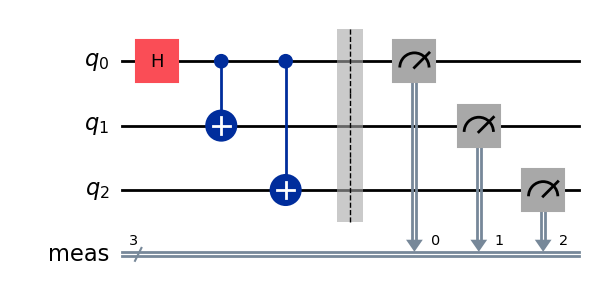

In [92]:
# Creating a sample circuit with Qiskit -> GHZ Circuit

qc1 = QuantumCircuit(3)
qc1.h(0)
qc1.cx(0, 1)
qc1.cx(0, 2)
qc1.measure_all()

qc1.draw(output='mpl')

In [93]:
# Circuit results simulated with Aer
from qiskit import transpile
from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend('basic_simulator')

qc1_trans = transpile(qc1, backend)
job = backend.run(qc1_trans)

result = job.result()
counts=result.get_counts()
print(counts)

{'111': 510, '000': 514}


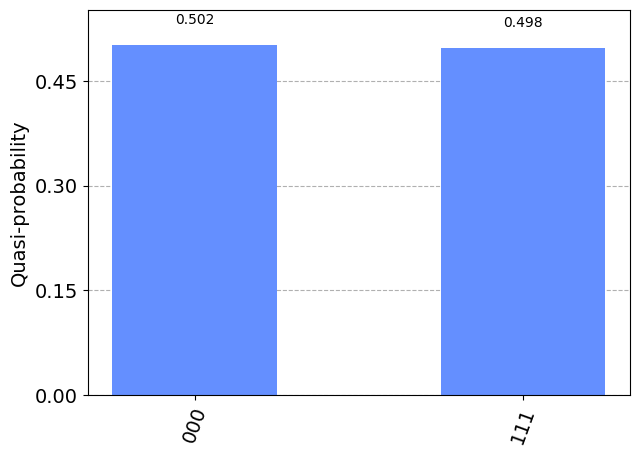

In [94]:
plot_distribution(counts)

In [95]:
# Circuit running on a real quantum device

#small_devices = provider.backends(min_num_qubits=5, simulator=False, operational=True)
#backend = least_busy(small_devices)
#print(backend)

#job = execute(qc1, backend = backend, shots=4000)
#result = job.result()
#counts=result.get_counts()
#print(counts)
#plot_distribution(counts)

![Intro](./images/real_device_stats.png)

### Building quantum circuits: Bernstein-Vazirani algorithm

Bernstein-Vazirani algorithm is one of special quantum algorithms which showed that there can be advantages in using a quantum computer as a computational tool for more complex problems.

There is a function returning the bitwise product of the input with a hidden string of bits $ s $. Its length is $ n $.

$$ f(x) = s ⋅ x (\mathrm{mod} 2) $$

To find the hidden string, we would need to call the function $f$ for $ n $ times. However, using a quantum computer, we can solve this problem with 100% confidence after **only one call** to the function . The quantum Bernstein-Vazirani algorithm to find the hidden bit string is very simple:

1. Initialize the inputs qubits to the state $|0\rangle^{\otimes n}$, and output qubit to $|-\rangle$.
2. Apply Hadamard gates to the input register
3. Query the oracle
4. Apply Hadamard gates to the input register
5. Measure

For more in detailed information about the Bernstein-Vazirani algorithm, feel free to check out this helpful chapter in the Qiskit textbook: **https://learn.qiskit.org/course/ch-algorithms/bernstein-vazirani-algorithm**.

In [96]:
def bernstein_vazirani(string):
    
    # Save the length of string
    string_length = len(string)
    
    qr = QuantumRegister(string_length, 'qr')
    cr = ClassicalRegister(string_length, 'cr')
    ar = AncillaRegister(1, 'ancilla')
    
    # Make a quantum circuit
    bv = QuantumCircuit(qr, ar, cr)
    
    # Initialize each input qubit to apply a Hadamard gate and output qubit to |->
    
    bv.x(string_length)
    bv.h(string_length)
    for i in range(string_length):
        bv.h(i)

    # Apply an oracle for the given string
    # Note: In Qiskit, numbers are assigned to the bits in a string from right to left
    bv.barrier()
    
    for i in reversed(range(string_length)):
        if string[i] == '1':
            bv.cx(string_length-1-i, string_length)
    
    # Apply Hadamard gates after querying the oracle
    bv.barrier()
    for i in range(string_length):
        bv.h(i)
    
    # Measurement
    bv.barrier()
    bv.measure(range(string_length), range(string_length))
    
    return bv

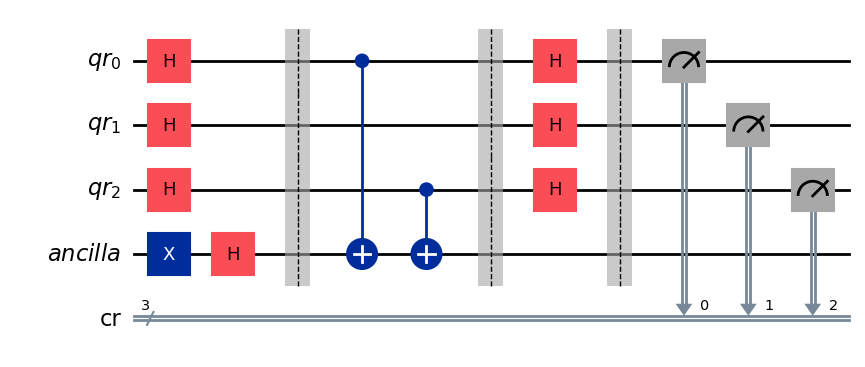

In [97]:
string = '101'
circuit = bernstein_vazirani(string)
display(circuit.draw(output="mpl"))


Bernstein Varizani Result for 101 :
{'101': 1024}



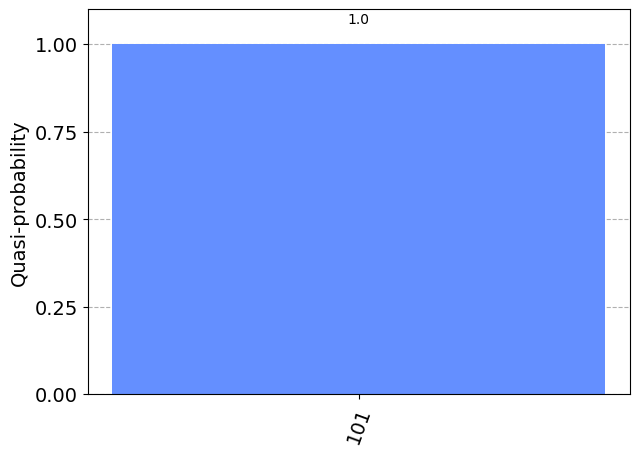

In [98]:
# Use local simulator

from qiskit_aer import Aer
backend = Aer.get_backend('statevector_simulator')
results = backend.run(circuit, shots = 1024).result()
answer = results.get_counts()

print()
print("Bernstein Varizani Result for", string, ":")
print(answer)
print()
plot_distribution(answer)

## Qiskit IBM Runtime 
**Runtime Architecture**
![Qiskit IBM Runtime](./images/runtime-architecture.png)
https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html

### Using Qiskit IBM Runtime Primitives - Sampler

|       |     |          |
| :---        |    :---   |          :--- |
| Sampler      | Allows a user to input a circuit and then generate quasiprobabilities. This generation enables users to more efficiently evaluate the possibility of multiple relevant data points in the context of destructive interference.       | ![Sampler](./images/sampler.png) |
|    |      |         |

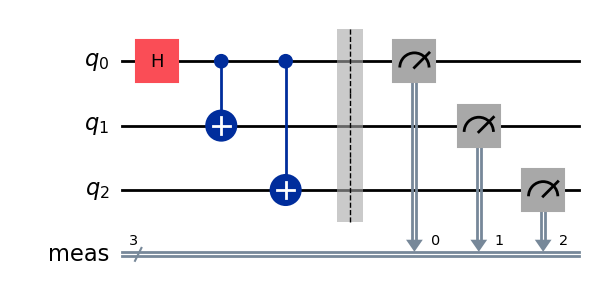

In [99]:
N = 3
qc2 = QuantumCircuit(N)
qc2.h(0)
for x in range(1, N):
  qc2.cx(0,x)
qc2.measure_all()


qc2.draw(output='mpl')
#qc2.decompose().draw(output='mpl')

In [100]:
from qiskit.primitives import StatevectorSampler as Sampler, StatevectorEstimator as Estimator

In [101]:
sampler = Sampler()
result = sampler.run([qc2], shots=8000).result()

data_pub = result[0].data

# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

The counts are: {'111': 4032, '000': 3968}


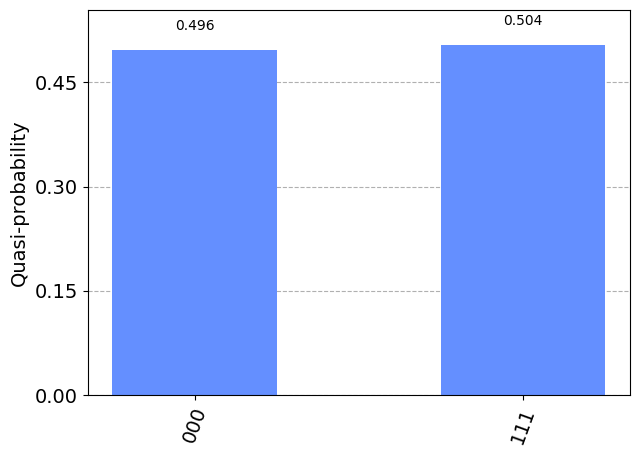

In [102]:
plot_distribution(counts)

### Using Qiskit IBM Runtime Primitives - Estimator 

|       |     |          |
| :---        |    :---   |          :--- |
| Estimator   | Allows a user to specify a list of circuits and observables and selectively group between the lists to efficiently evaluate expectation values and variances for a parameter input. It is designed to enable users to efficiently calculate and interpret expectation values of quantum operators that are required for many algorithms.        |  ![Sampler](./images/estimator.png)   |
|    |      |         |

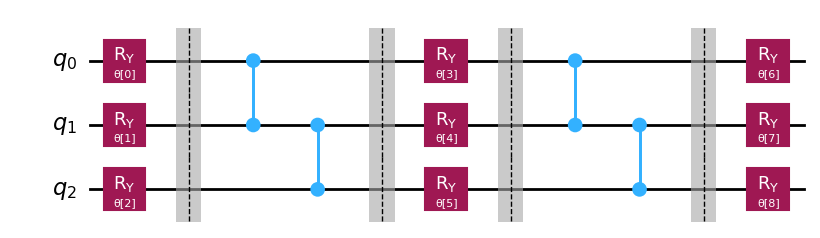

In [103]:
from qiskit.circuit.library import TwoLocal

qc3 = TwoLocal(3, "ry", "cz", reps=2, entanglement="linear", insert_barriers=True)

#qc3.draw('mpl')
qc3.decompose().draw('mpl')

In [104]:
# creating sample Hamiltonian and calculating the expectation value
from qiskit.quantum_info import SparsePauliOp
import math

H1 = SparsePauliOp.from_list([("IZZ", 0.5), ("ZIZ", 1), ("ZZI", 1.5)])
theta1 = [-1.02570186,  0.26172088,  0.81759369,  0.90749673,  0.77320923,  2.58210241,
  0.07412267,  0.92345479, -0.24843503]
    

estimator = Estimator()
psi1_H1_result = estimator.run([(qc3, H1, theta1)]).result()

print(f"job id: {job.job_id()}") 
print()
print("Expectation Value of <psi1(theta1)|H1|psi1(theta1)>:")
print(psi1_H1_result)


job id: db84c256-3860-4efa-9e4e-06ed1c8c54c6

Expectation Value of <psi1(theta1)|H1|psi1(theta1)>:
PrimitiveResult([PubResult(data=DataBin<>(evs=-1.98903689397857, stds=0.0), metadata={'precision': 0.0})], metadata={})


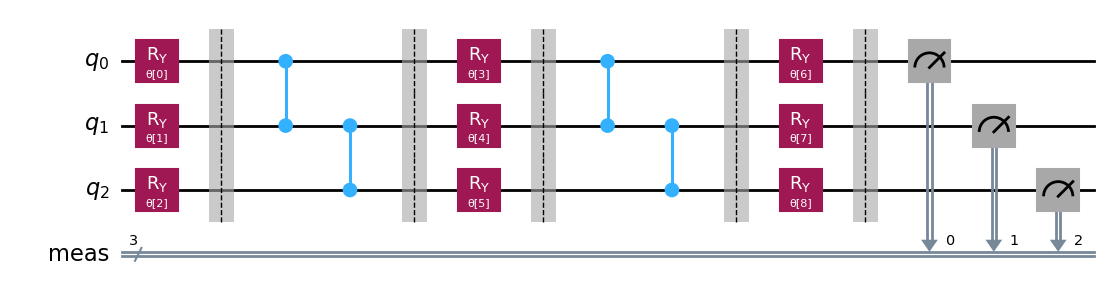

In [105]:
qc3.measure_all()
qc3.decompose().draw('mpl')

In [106]:
sampler = Sampler()
sampler_result = sampler.run([(qc3, theta1)], shots=1000).result()

data_pub = sampler_result[0].data
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

The counts are: {'100': 982, '010': 5, '011': 6, '111': 1, '101': 5, '110': 1}


In [107]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
service = QiskitRuntimeService(channel="ibm_quantum")
device = service.backend("ibmq_qasm_simulator")
device

<IBMBackend('ibmq_qasm_simulator')>

In [108]:
sampler_real = SamplerV2(backend = device)
sampler_result = sampler_real.run([(qc3,theta1)], shots=1000).result()
data_pub = sampler_result[0].data
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

RuntimeJobFailureError: 'Unable to retrieve job result. Circuits do not match the target definition (non-ISA circuits). -- \\n        Transpile your circuits for the target before submitting a primitive query. For\\n        example, you can use the following code block given an IBMBackend object `backend`\\n        and circuits of type `List[QuantumCircuit]`:\\n            from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager\\n            pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)\\n            isa_circuits = pm.run(circuits)\\n        Then pass `isa_circuits` to the Sampler or Estimator.\\n         -- https://ibm.biz/error_codes#1517'

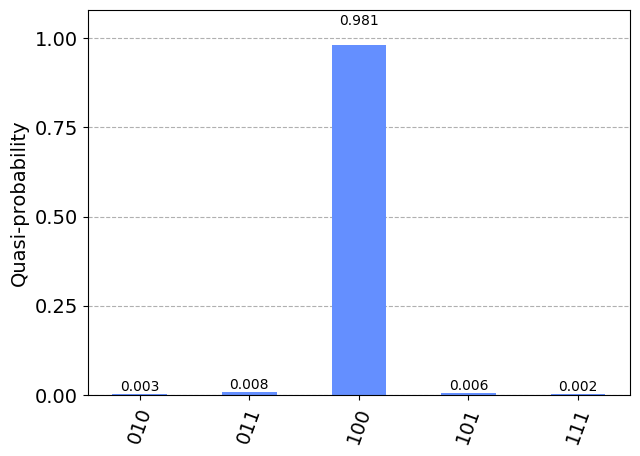

In [22]:
plot_distribution(sampler_result.quasi_dists[0].binary_probabilities())

## Dynamic Circuits
Dynamic circuits are quantum circuits that contain mid-circuit measurements that affect the control flow of gate execution later in the circuit, otherwise known as feed-forward operations. 

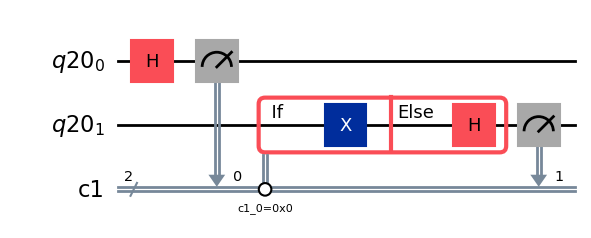

In [109]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc4 = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc4.h(q0)
qc4.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc4.if_test((b0, 0)) as else_:
    qc4.x(q1)
with else_:
    qc4.h(q1)
    
qc4.measure(q1, b1)
qc4.draw(output="mpl", idle_wires=False)

In [110]:
# running dynamic circuits
backend = Aer.get_backend('statevector_simulator')

result = backend.run(qc4, shots=100).result()

print(result.get_counts())

{'11': 20, '10': 53, '01': 27}


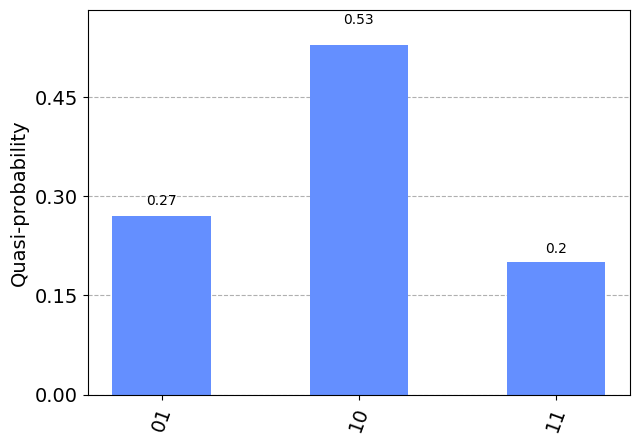

In [111]:
plot_distribution(result.get_counts())

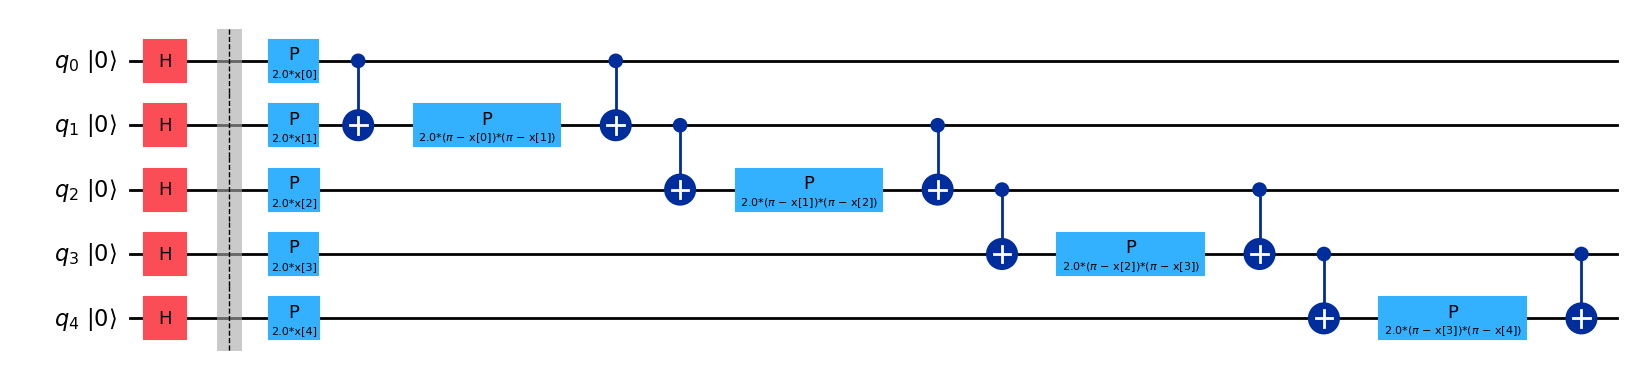

In [112]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
num_qubits = 5
map_zz = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement="linear", insert_barriers=True)
map_zz.decompose().draw(output="mpl", style="iqp", initial_state=True, scale=1)

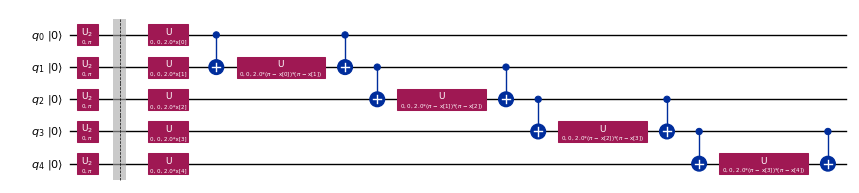

In [114]:
#from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2
from qiskit_ibm_runtime.fake_provider import FakeProvider
from qiskit import transpile

backend1 = FakeProvider().get_backend("fake_manila")

tp_map_zz = transpile(map_zz, backend)
tp_map_zz.decompose().draw(output="mpl", style="iqp", initial_state=True, scale=0.5
    )

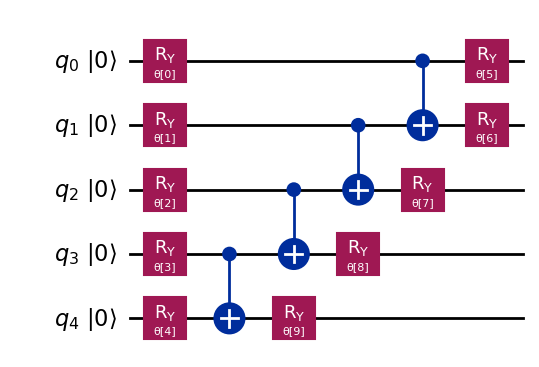

In [115]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(5, reps=1, parameter_prefix='θ', insert_barriers=False)
ansatz.decompose().draw(output="mpl", style="iqp", initial_state=True, scale=1)

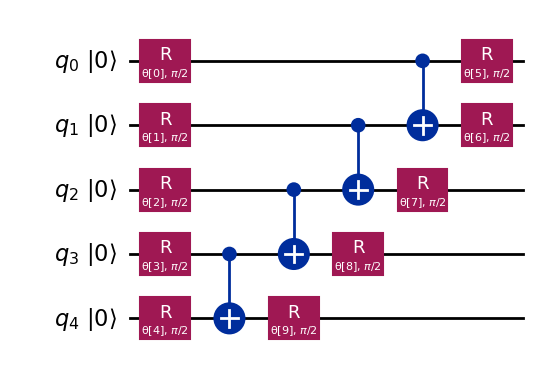

In [116]:
tp_ansatz = transpile(ansatz, backend)
tp_ansatz.decompose().draw(output="mpl", style="iqp", initial_state=True, scale=1)

In [125]:
import qiskit
import qiskit_ibm_runtime

print(
"Qiskit Version: ", qiskit.version.get_version_info())
print(
"Qiskit IBM Runtime Version: ", qiskit_ibm_runtime.version.get_version_info())



Qiskit Version:  1.0.2
Qiskit IBM Runtime Version:  0.21.2
